In [ ]:
# This tests how we find errors for our calibration program star metallicities, and how we
# find final error bars on our calibration solution coefficients

# created 2018 Jan 14 by E.S.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy
import scipy.stats as stats
from scipy import interpolate
from astropy.modeling.functional_models import Gaussian2D
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

In [2]:
# make some fake data representing the metallicities and errors of stars from the literature

'''
fake_data_1 = {"star_name": ["AA Aql","AO Peg","BR Aqr","CI And","DM Cyg","DO Vir","DX Del","X Ari"],
                "feh_lit": [-1.1,-0.6,-1.29,-1.22,-0.69,-0.43,-0.04,-2.51],
                "feh_layden": [-1.05,-0.9,-1.15,-1.2,-0.45,-0.7,0.0,-2.1],
                "err_feh_lit": [0.3,0.3,0.3,0.4,0.2,0.35,0.3,0.4],
                "err_feh_layden": [0.06,0.06,0.07,0.06,0.07,0.06,0.06,0.07]}

fake_dataset_1 = pd.DataFrame(data=fake_data_1)
'''

In [4]:
# read in actual data

real_data_1 = pickle.load( open( "info.pkl", "rb" ) )

In [5]:
# arrange the data in a way we can use
# N.b. This is NOT fake data; I'm just appropriating the old variable name

fake_data_1 = { "star_name": real_data_1[0]["name_star"],
                "feh_lit": real_data_1[0]["FeH_highres"],
                "feh_layden": real_data_1[0]["FeH_basis"],
                "err_feh_lit": np.zeros(len(real_data_1[0]["FeH_basis"])),
                "err_feh_layden": 0.07*np.ones(len(real_data_1[0]["FeH_basis"]))}

fake_dataset_1 = pd.DataFrame(data=fake_data_1)

In [6]:
# show the points we are working with

'''
plt.errorbar(fake_data_1["feh_layden"], fake_data_1["feh_lit"], 
             yerr=fake_data_1["err_feh_lit"], xerr=fake_data_1["err_feh_layden"], marker="s", linestyle='')
plt.xlabel("Fake Layden 94 Fe/H")
plt.ylabel("Fake Literature Fe/H")
plt.savefig("fake_data.png")
#plt.show()
'''

'\nplt.errorbar(fake_data_1["feh_layden"], fake_data_1["feh_lit"], \n             yerr=fake_data_1["err_feh_lit"], xerr=fake_data_1["err_feh_layden"], marker="s", linestyle=\'\')\nplt.xlabel("Fake Layden 94 Fe/H")\nplt.ylabel("Fake Literature Fe/H")\nplt.savefig("fake_data.png")\n#plt.show()\n'

# Step 1: Find the linear regression line to high_res vs. basis Fe/H values

In [7]:
# Put Fe/H values into a useable form

feh_sample = np.transpose([fake_data_1["feh_layden"],fake_data_1["feh_lit"]])

In [9]:
# Bootstrap

N_samples = int(1e4)

# set RNG for reproducibility
with NumpyRNGContext(1):
    bootresult = bootstrap(feh_sample, N_samples)

In [10]:
# for testing results with different seeds
#bootresult = bootstrap(feh_sample, N_samples)

In [11]:
def cdf_fcn(array_input):
    '''
    Return CDF of an unsorted input array of values
    '''
    
    number_cum_norm = np.divide(np.arange(len(array_input)),len(array_input))
    array_input_sort = np.sort(array_input)
    array_cdf = np.divide(np.cumsum(array_input_sort),np.cumsum(array_input_sort)[-1])
    
    return array_input_sort, number_cum_norm

In [12]:
def cdf_gauss(x_range, mu, sig):
    '''
    Returns the CDF of a general Gaussian function for any mu and sig
    '''
    
    x_range_adjust = np.divide(np.subtract(x_range, mu), sig) # rescale x -> x* = (x-mu)/sig
    erf_return = scipy.special.erf(np.divide(x_range_adjust,np.sqrt(2))) # erf(x*/sqrt(2))
    
    return np.multiply(0.5,np.add(1., erf_return)) # (1/2)*(1 + erf(x*/sqrt(2)))

In [13]:
# test of cdf_fcn and cdf_gauss

'''
x_range = np.arange(-5,5,0.01)
mu = -2.
sig = 2

# sample from a gaussian distribution
gaussian_samples = np.random.normal(loc=mu, scale=sig, size=len(x_range))

# test my cdf_fcn
x_range1, y_range1 = cdf_fcn(gaussian_samples)

# test my cdf_gauss fcn
y_range = cdf_gauss(x_range, mu, sig)

plt.plot(x_range, y_range, color='blue')
plt.plot(x_range1, y_range1, color='red')
plt.show()
'''

"\nx_range = np.arange(-5,5,0.01)\nmu = -2.\nsig = 2\n\n# sample from a gaussian distribution\ngaussian_samples = np.random.normal(loc=mu, scale=sig, size=len(x_range))\n\n# test my cdf_fcn\nx_range1, y_range1 = cdf_fcn(gaussian_samples)\n\n# test my cdf_gauss fcn\ny_range = cdf_gauss(x_range, mu, sig)\n\nplt.plot(x_range, y_range, color='blue')\nplt.plot(x_range1, y_range1, color='red')\nplt.show()\n"

In [14]:
# populate the arrays with bootstrap results

m_array = np.nan*np.ones(len(bootresult))
b_array = np.nan*np.ones(len(bootresult))
for boot_n in range(0,len(bootresult)):
    test_fit = np.polyfit(bootresult[boot_n,:,0], bootresult[boot_n,:,1], 1)
    m_array[boot_n] = test_fit[0]
    b_array[boot_n] = test_fit[1]

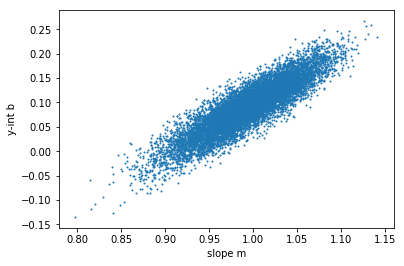

In [15]:
# show m-b space

plt.scatter(m_array,b_array,s=1)
plt.xlabel("slope m")
plt.ylabel("y-int b")
plt.savefig("line_params.png")
plt.show()

[0.99529299 0.04564448]


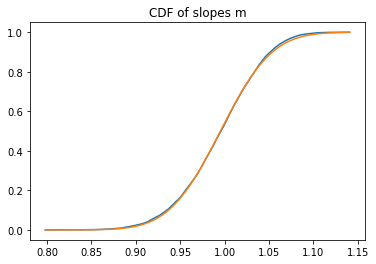

In [16]:
# make empirical CDF of m

x_vals, y_vals = cdf_fcn(m_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))
plt.title("CDF of slopes m")
plt.savefig("line_param_cdf_m.png")
plt.show()

[0.09294489 0.05321327]


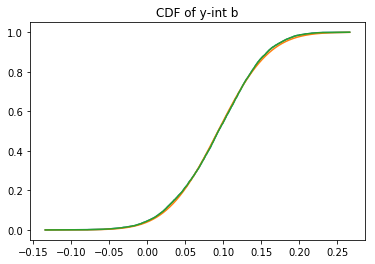

In [17]:
# make empirical CDF of b

x_vals, y_vals = cdf_fcn(b_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))

plt.plot(x_vals, y_vals)
plt.title("CDF of y-int b")
plt.savefig("line_param_cdf_b.png")
plt.show()

In [21]:
def make_hist_plot(name_star,feh_mapped_array):

    plt.clf()
    plt.hist(np.ravel(feh_mapped_array), bins = 100)
    plt.title(name_star + "\n" + "std = "+str(np.std(np.ravel(feh_mapped_array))))
    plt.xlabel("Fe/H")
    plt.tight_layout()
    plt.savefig("junk_images/" + name_star + "_hist.pdf")
    plt.close()

In [22]:
def make_cdf_plot(name_star,feh_mapped_array):

    x_vals, y_vals = cdf_fcn(np.ravel(feh_mapped_array))

    # fit a Gaussian
    popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)

    print("Line parameters")
    print(popt)

    xvals_interp = np.arange(x_vals[0], x_vals[-1], 0.001)
    yvals_interp = np.interp(xvals_interp, x_vals, y_vals)

    # find element of value closest to 0.5
    percent_bar = 0.5
    idx = np.abs(yvals_interp - percent_bar).argmin()


    # ---------------------------------------------------------------------------

    # SIGMA DEFINITION 1: FIND MEDIAN AND SIGMA BRACKETS AROUND IT
    # find element of value closest to 1-sigma limit (on low side)
    percent_bar_1sig_low = 0.5 - 0.5*0.682689492
    idx_1sig_low = np.abs(yvals_interp - percent_bar_1sig_low).argmin()
    # find element of value closest to 1-sigma limit (on high side)
    percent_bar_1sig_high = 0.5 + 0.5*0.682689492
    idx_1sig_high = np.abs(yvals_interp - percent_bar_1sig_high).argmin()

    # SIGMA DEFINITION 2: FIND NARROWEST REGION CONTAINING 1-SIGMA WORTH OF POINTS
    shortest_xrange = xvals_interp[-1] - xvals_interp[0]
    shortest_xrange_lower = xvals_interp[0]

    for t in range(0,len(xvals_interp)):
    
        lower_bar_y = yvals_interp[t]
        upper_bar_y = yvals_interp[t] + 0.682689492
    
        # break if the range will go beyond data points
        if (upper_bar_y > 0.99):
            break
    
        idx_1sig_here = t
        idx_1sig_above = np.abs(yvals_interp - upper_bar_y).argmin()
    
        if (np.subtract(xvals_interp[idx_1sig_above],
                        xvals_interp[idx_1sig_here]) < shortest_xrange):
        
            shortest_xrange = xvals_interp[idx_1sig_above] - xvals_interp[idx_1sig_here]
            shortest_xrange_lower = xvals_interp[idx_1sig_here]
            shortest_xrange_upper = xvals_interp[idx_1sig_above]
            shortest_xrange_halfway = 0.5*np.subtract(shortest_xrange_upper,shortest_xrange_lower)+shortest_xrange_lower

    # ---------------------------------------------------------------------------

    # test how gaussian the data is, based on earlier fit
    print("K-S test")
    print(stats.kstest(y_vals, 'norm', args=popt)[0])
    print(stats.kstest(y_vals, 'norm', args=popt)[1])
    
    print("Fe/H at 50 percentile")
    print(xvals_interp[idx])

    print("1-sigma interval")
    print(xvals_interp[idx_1sig_low])
    print(xvals_interp[idx_1sig_high])

    plt.clf()
    plt.plot(x_vals, y_vals)
    plt.plot(x_vals, cdf_gauss(x_vals, *popt), linestyle=":", color="k")
    plt.axvline(xvals_interp[idx], color='blue')
    plt.axvline(xvals_interp[idx_1sig_low], color='blue')
    plt.axvline(xvals_interp[idx_1sig_high], color='blue')
    plt.axvline(shortest_xrange_lower, color='orange')
    plt.axvline(shortest_xrange_upper, color='orange')
    plt.axvline(shortest_xrange_halfway, color='orange')
    plt.xlabel("Fe/H")
    plt.ylabel("CDF")
    plt.title(name_star + "\n"+\
          "Fe/H based on median (blue): "
          + "{:.{}f}".format( xvals_interp[idx], 3) + ", +" + "{:.{}f}".format( np.subtract(xvals_interp[idx_1sig_high],xvals_interp[idx]), 3) 
          + ", -" + "{:.{}f}".format( np.subtract(xvals_interp[idx],xvals_interp[idx_1sig_low]), 3) +"\n"+\
          "Fe/H based on shortest range (orange): "
          + "{:.{}f}".format( shortest_xrange_halfway, 3) + ", +" + "{:.{}f}".format( np.subtract(shortest_xrange_upper,shortest_xrange_halfway), 3) 
          + ", -" + "{:.{}f}".format( np.subtract(shortest_xrange_halfway,shortest_xrange_lower), 3))
    plt.tight_layout()
    plt.savefig("junk_images/" + name_star + "_cdf.pdf")
    plt.close()

Star:
SW And
Layden Fe/H:
-0.38
Line parameters
[-0.28734775  0.04618742]
K-S test
0.9999999997535411
0.0
Fe/H at 50 percentile
-0.2867995086058243
1-sigma interval
-0.33379950860582436
-0.24179950860582428
Elapsed time:
5.123814105987549
--------------------------
Star:
X Ari
Layden Fe/H:
-2.4


KeyboardInterrupt: 

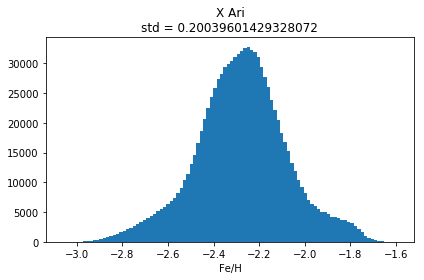

In [20]:
## ## BIG LOOP HERE FOR MAPPING

# take one basis set Fe/H (discrete value only) and find what the mapped value should be 

for layden_feh_num in range(0,len(fake_data_1["star_name"][:].unique())):
    time_start = time.time()
    feh_mapped_array = np.nan*np.ones(len(m_array)) # initialize array
    
    # get name and Layden Fe/H of star
    name_star = fake_data_1["star_name"][:].unique()[layden_feh_num] 
    feh_test = fake_data_1["feh_layden"][:].unique()[layden_feh_num]
    print("Star:")
    print(name_star)
    print("Layden Fe/H:")
    print(feh_test)
    
    for sample_num in range(0,len(m_array)):
    
        feh_mapped_1sample = m_array[sample_num]*feh_test + b_array[sample_num]
        feh_mapped_array[sample_num] = feh_mapped_1sample
        
    # take one basis set Fe/H (integral over a Gaussian) and find what the mapped value should be 
    N = 100 # number of samples to take within the Gaussian error around Layden's Fe/H value
    gaussian_spread = 0.07
    layden_feh = feh_test # this is the discrete value
    feh_mapped_array = np.nan*np.ones((len(m_array),N)) # N_m_samples x N_Layden_samples

    # loop over each sample within the Gaussian around Layden's Fe/H
    for integal_piece in range(0,N):
    
        # set the offset (note mu=0; this is a relative offset)
        offset = np.random.normal(loc = 0.0, scale = gaussian_spread)
    
        # loop over all (m,b) combinations found further above
        for sample_num in range(0,len(m_array)):
    
            feh_mapped_1sample = m_array[sample_num]*layden_feh*(1. + offset) + b_array[sample_num]
            feh_mapped_array[sample_num][integal_piece] = feh_mapped_1sample
    
    # make plots
    make_hist_plot(name_star,feh_mapped_array)
    make_cdf_plot(name_star,feh_mapped_array)

    print("Elapsed time:")
    print(str(time.time() - time_start))
    print("--------------------------")

# Step 2: Find the remapping of literature metallicities, with errors

# Step 3: Find the calibration coefficients (a,b,c,d) with errors